In [1]:
# %%
import numpy as np
import scvelo as scv
import torch
from umap import UMAP
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu

from deepvelo.utils import velocity, velocity_confidence, update_dict
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants


# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params(
    "scvelo", transparent=False
)  # for beautified visualization

Using backend: pytorch


# Load DG data and preprocess

In [2]:
adata = scv.datasets.dentategyrus()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)

Filtered out 10340 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# DeepVelo

In [3]:
# specific configs to overide the default configs
configs = {
    "name": "DeepVelo", # name of the experiment
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata)}},
    "trainer": {"verbosity": 0}, # increase verbosity to show training progress
}
configs = update_dict(Constants.default_configs, configs)

The ratio of spliced reads is 89.5% (more than 85%). Suggest using coeff_s 1.0.


In [4]:
# initial velocity
velocity(adata, mask_zero=False)
trainer = train(adata, configs)


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
building graph


INFO:train:Beginning training of DeepVelo ...


velo data shape: torch.Size([2930, 2000])


velo_mat shape: (2930, 2000)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)


In [5]:
scv.tl.velocity_graph(adata, n_jobs=8)

computing velocity graph (using 8/8 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


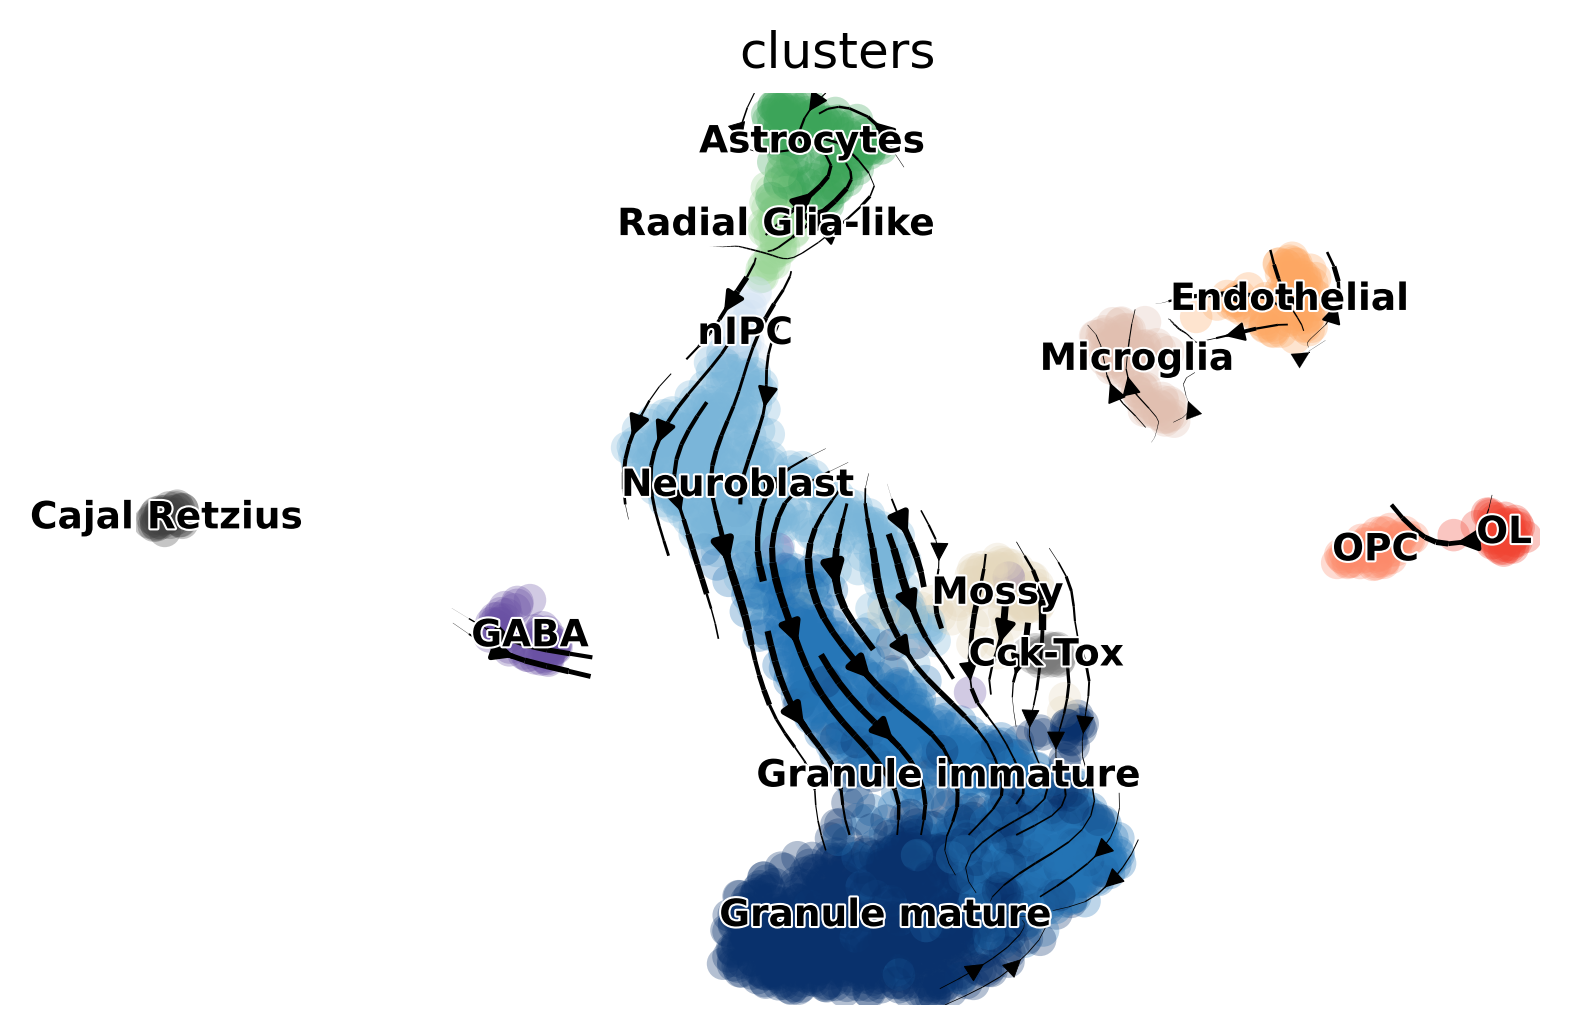

In [6]:
# velocity plot
scv.pl.velocity_embedding_stream(
    adata,
    basis="umap",
    color="clusters",
    legend_fontsize=9,
    dpi=150            # increase dpi for higher resolution
)


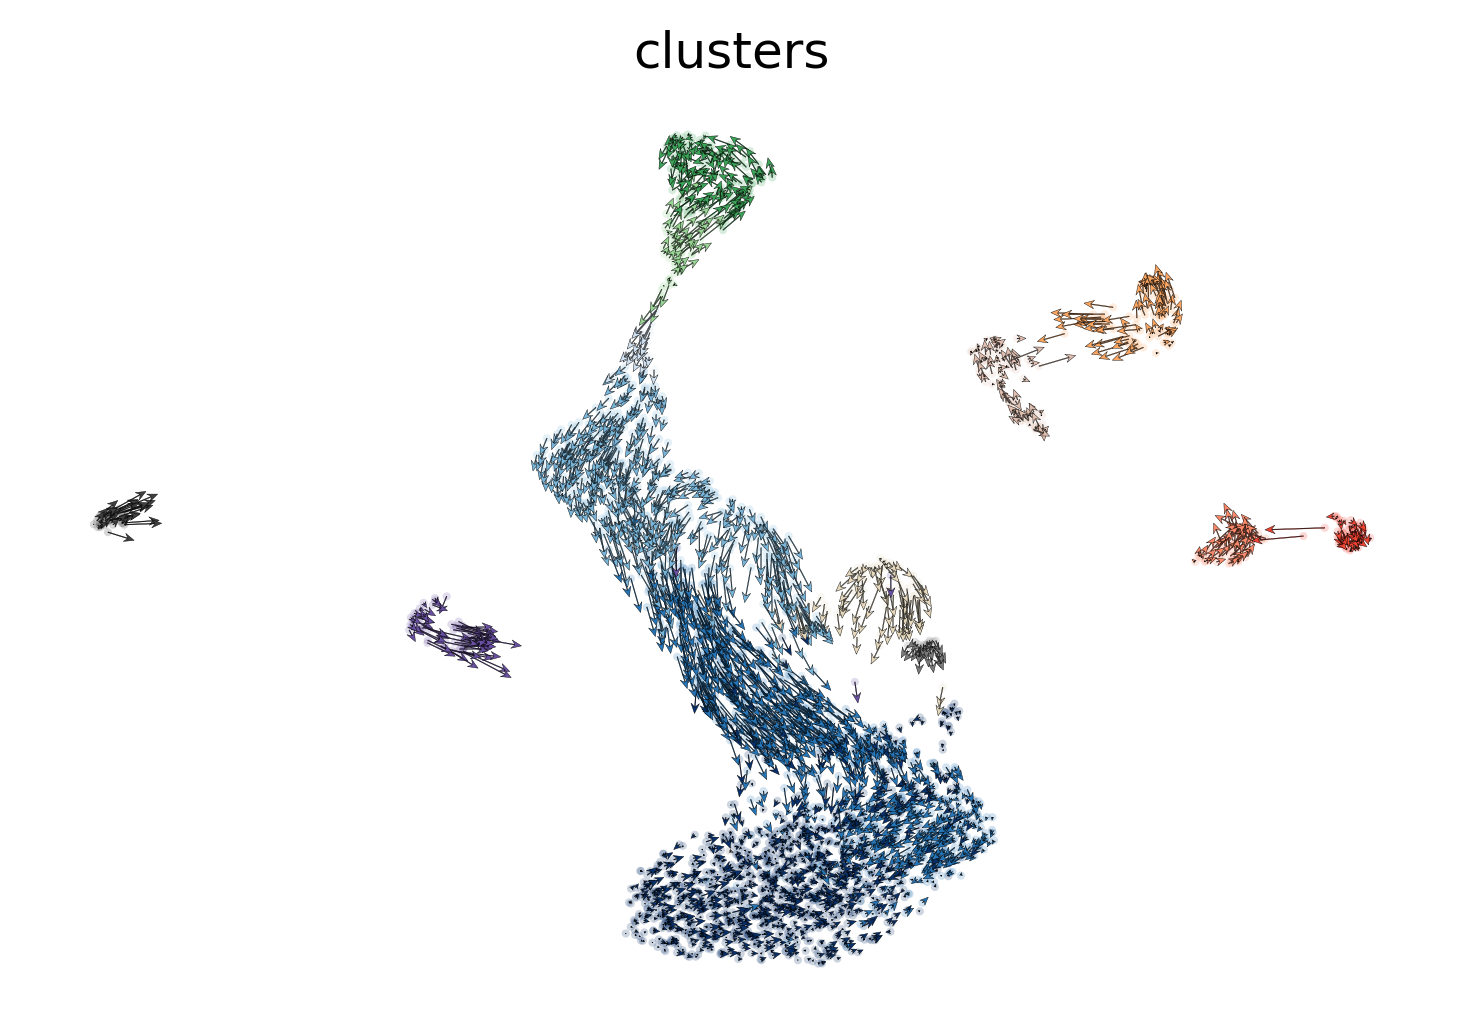

In [7]:
scv.pl.velocity_embedding(
    adata,
    basis="umap",
    arrow_length=6,
    arrow_size=1.2,
    dpi=150,
)


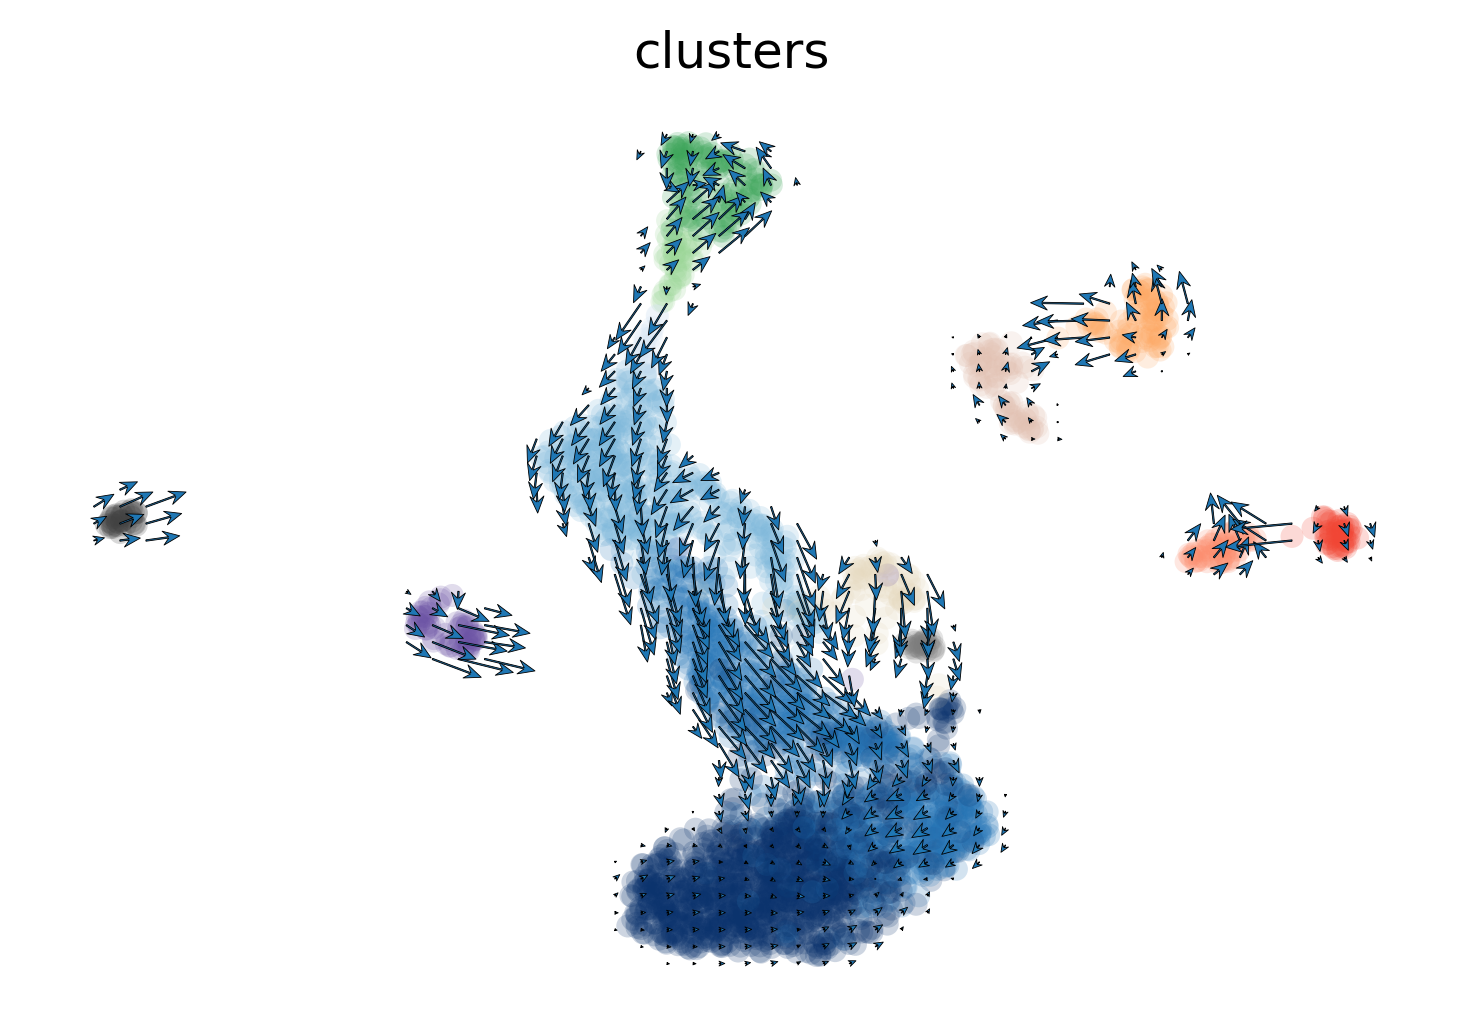

In [8]:
scv.pl.velocity_embedding_grid(
    adata,
    basis="umap",
    arrow_length=4,
    # alpha=0.1,
    arrow_size=2,
    arrow_color="tab:blue",
    dpi=150,
)


In [9]:
# get kinetic_rates
if "cell_specific_alpha" in adata.layers:
    all_rates = np.concatenate(
        [
            adata.layers["cell_specific_beta"],
            adata.layers["cell_specific_gamma"],
            adata.layers["cell_specific_alpha"],
        ],
        axis=1,
    )
else:
    all_rates = np.concatenate(
        [
            adata.layers["cell_specific_beta"],
            adata.layers["cell_specific_gamma"],
        ],
        axis=1,
    )
# pca and umap of all rates
rates_pca = PCA(n_components=30, random_state=SEED).fit_transform(all_rates)
adata.obsm["X_rates_pca"] = rates_pca

rates_umap = UMAP(
    n_neighbors=60,
    min_dist=0.6,
    spread=0.9,
    random_state=SEED,
).fit_transform(rates_pca)
adata.obsm["X_rates_umap"] = rates_umap


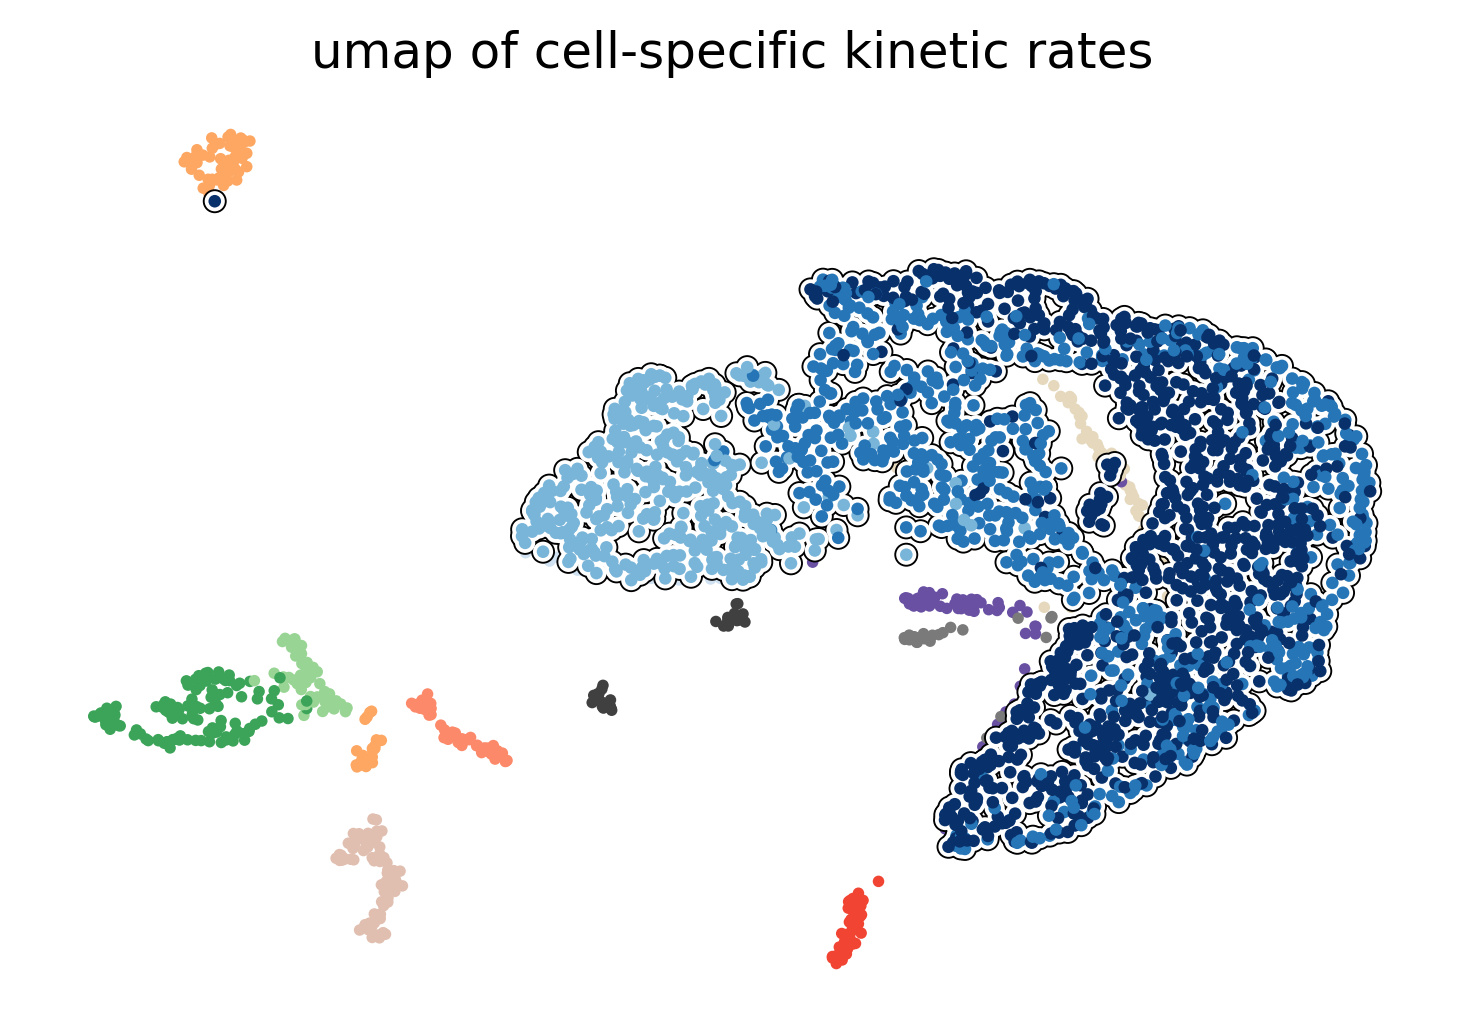

In [10]:
# plot kinetic rates umap
scv.pl.scatter(
    adata,
    basis="rates_umap",
    # omit_velocity_fit=True,
    add_outline="Granule mature, Granule immature, Neuroblast",
    outline_width=(0.15, 0.3),
    title="umap of cell-specific kinetic rates",
    legend_loc="none",
    dpi=150,
)

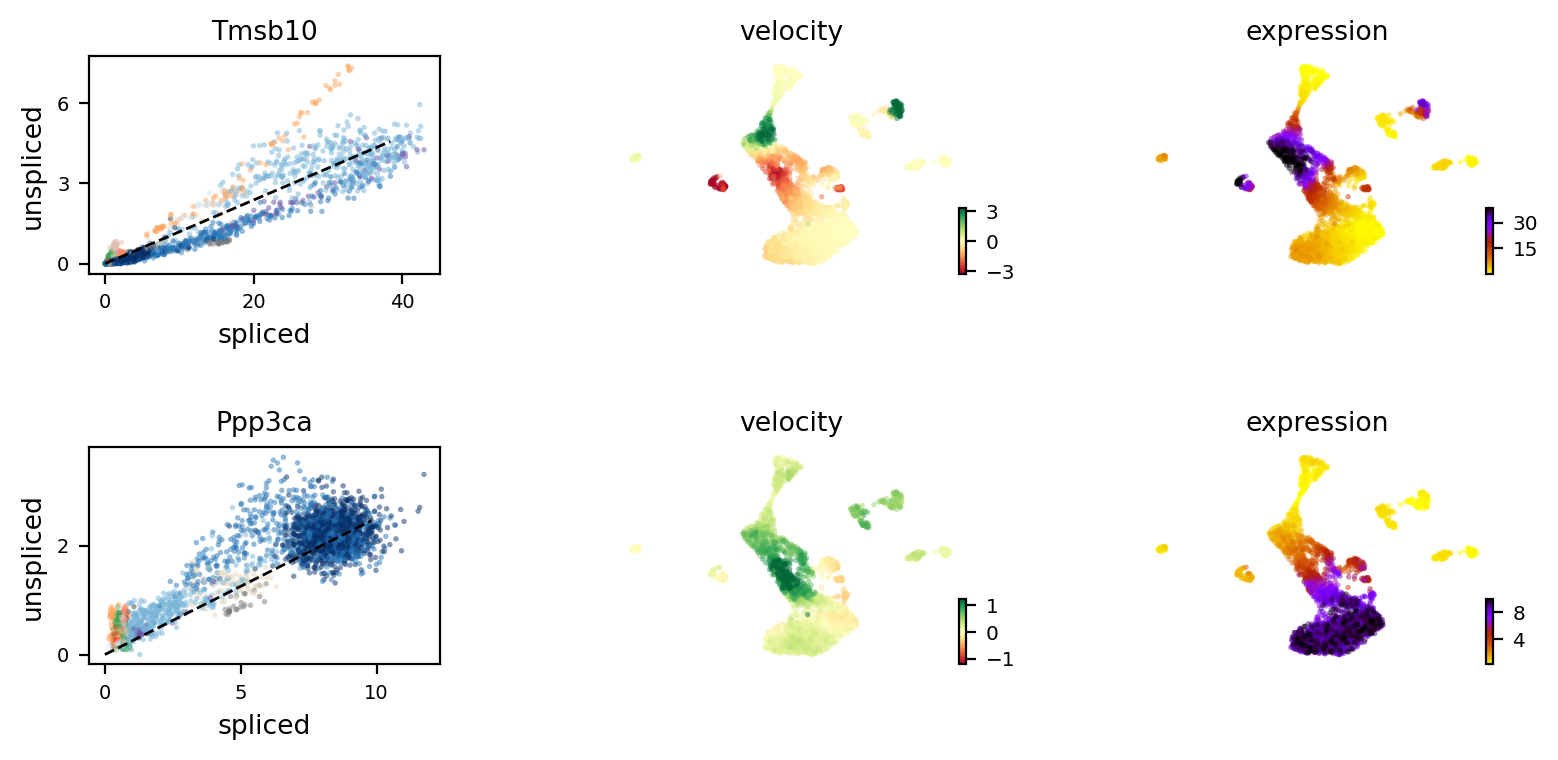

In [11]:
# plot genes
scv.pl.velocity(
    adata,
    var_names=["Tmsb10", "Ppp3ca"],
    basis="umap",
)

In [12]:
# save adata for next steps
deepvelo_adata = adata.copy()

# scVelo (dynamical)

In [13]:
adata = scv.datasets.dentategyrus()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)

Filtered out 10340 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [14]:
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.velocity(adata, mode="dynamical")


recovering dynamics (using 8/8 cores)


  0%|          | 0/975 [00:00<?, ?gene/s]

    finished (0:01:11) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [15]:
scv.tl.velocity_graph(adata, n_jobs=8)


computing velocity graph (using 8/8 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


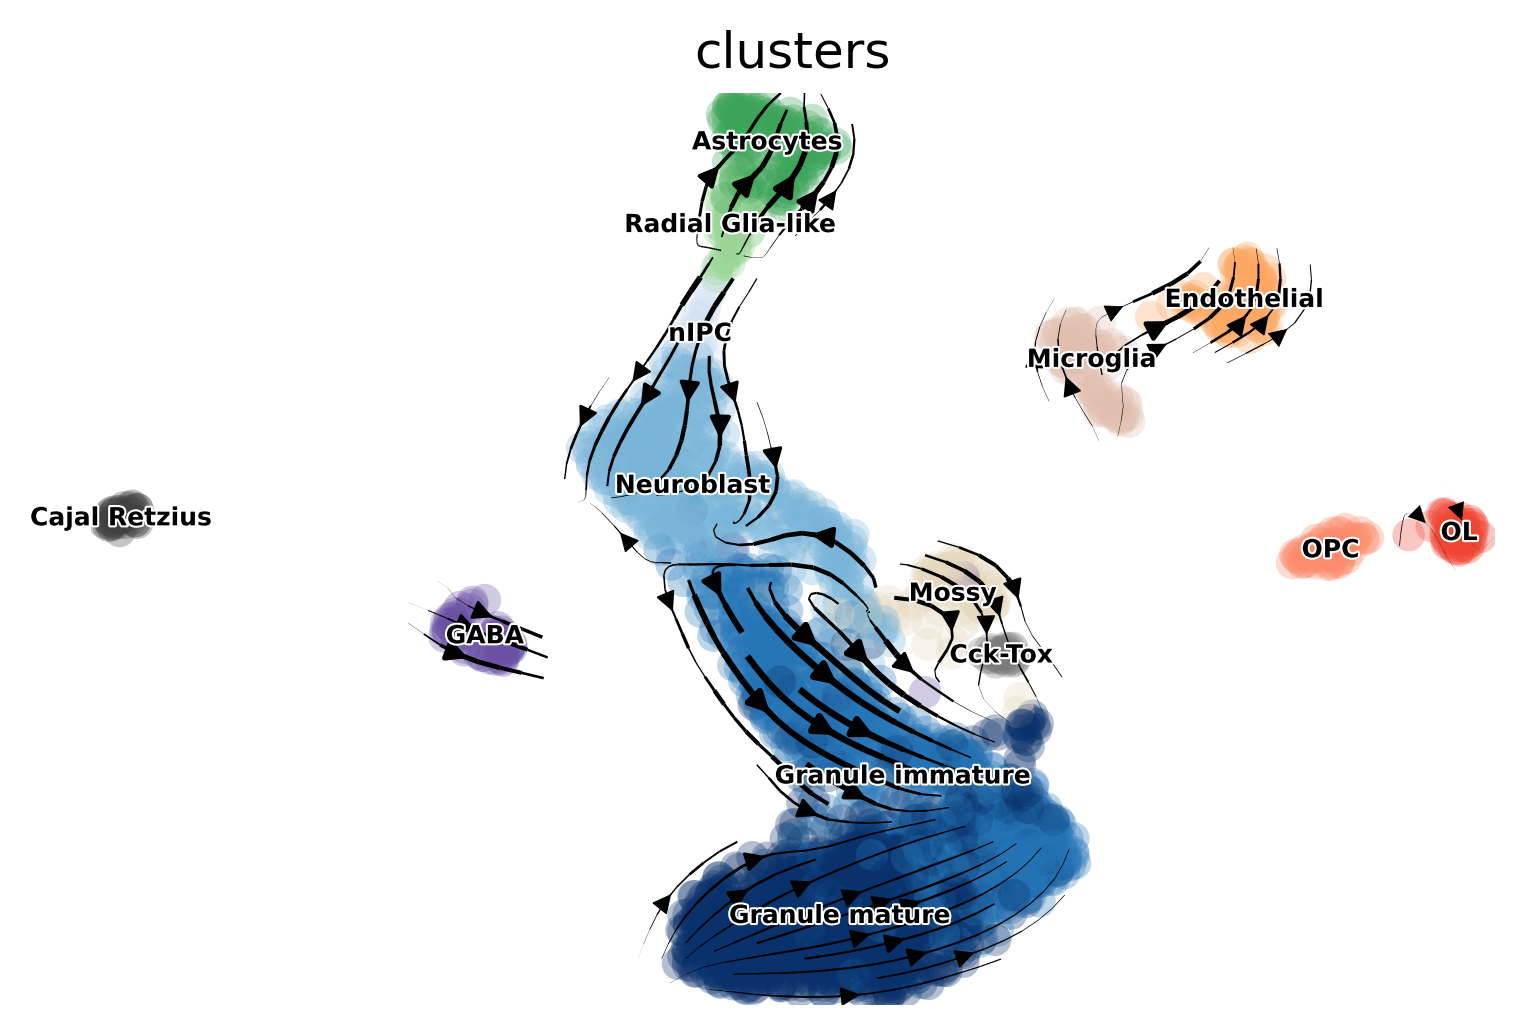

In [16]:
# velocity plot
scv.pl.velocity_embedding_stream(
    adata,
    basis="umap",
    color="clusters",
    legend_fontsize=6,
    dpi=150            # increase dpi for higher resolution
)

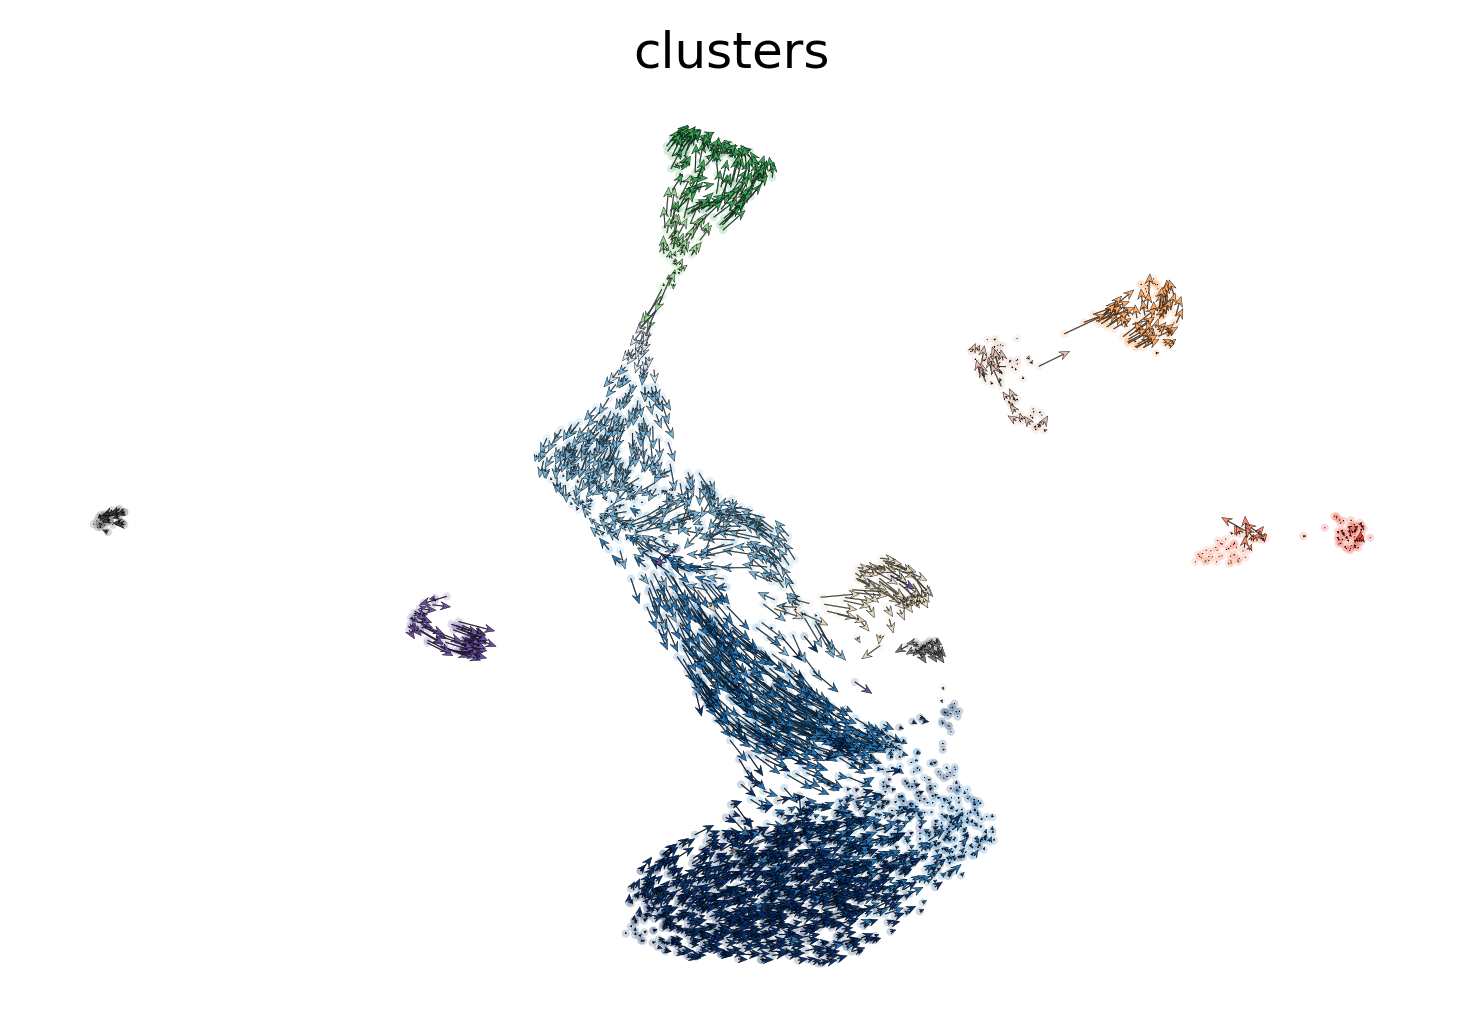

In [17]:
scv.pl.velocity_embedding(
    adata,
    basis="umap",
    arrow_length=6,
    arrow_size=1.2,
    dpi=150,
)

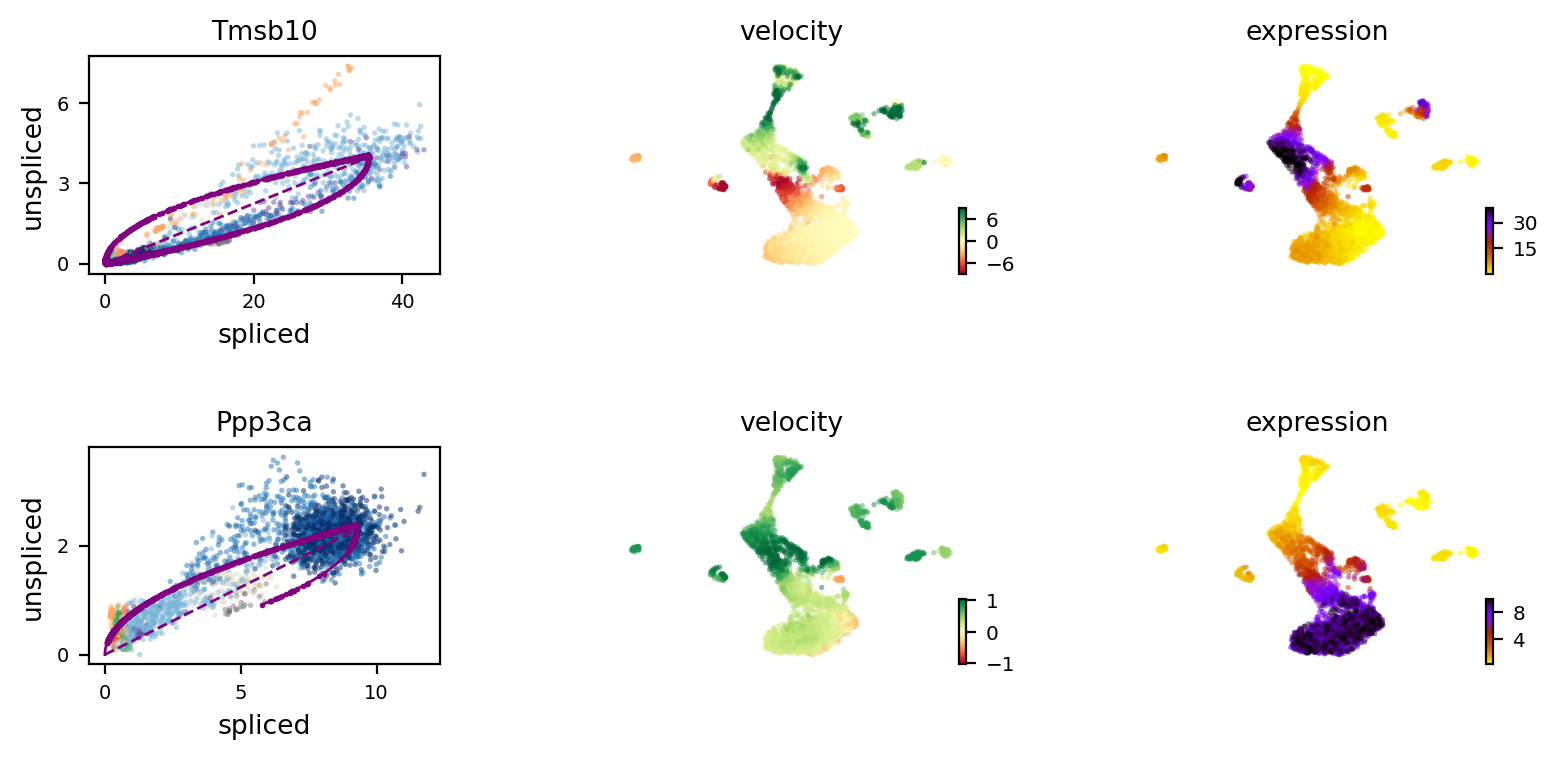

In [18]:
# plot genes
scv.pl.velocity(
    adata,
    var_names=["Tmsb10", "Ppp3ca"],
    basis="umap",
)

computing terminal states
    identified 5 regions of root cells and 3 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


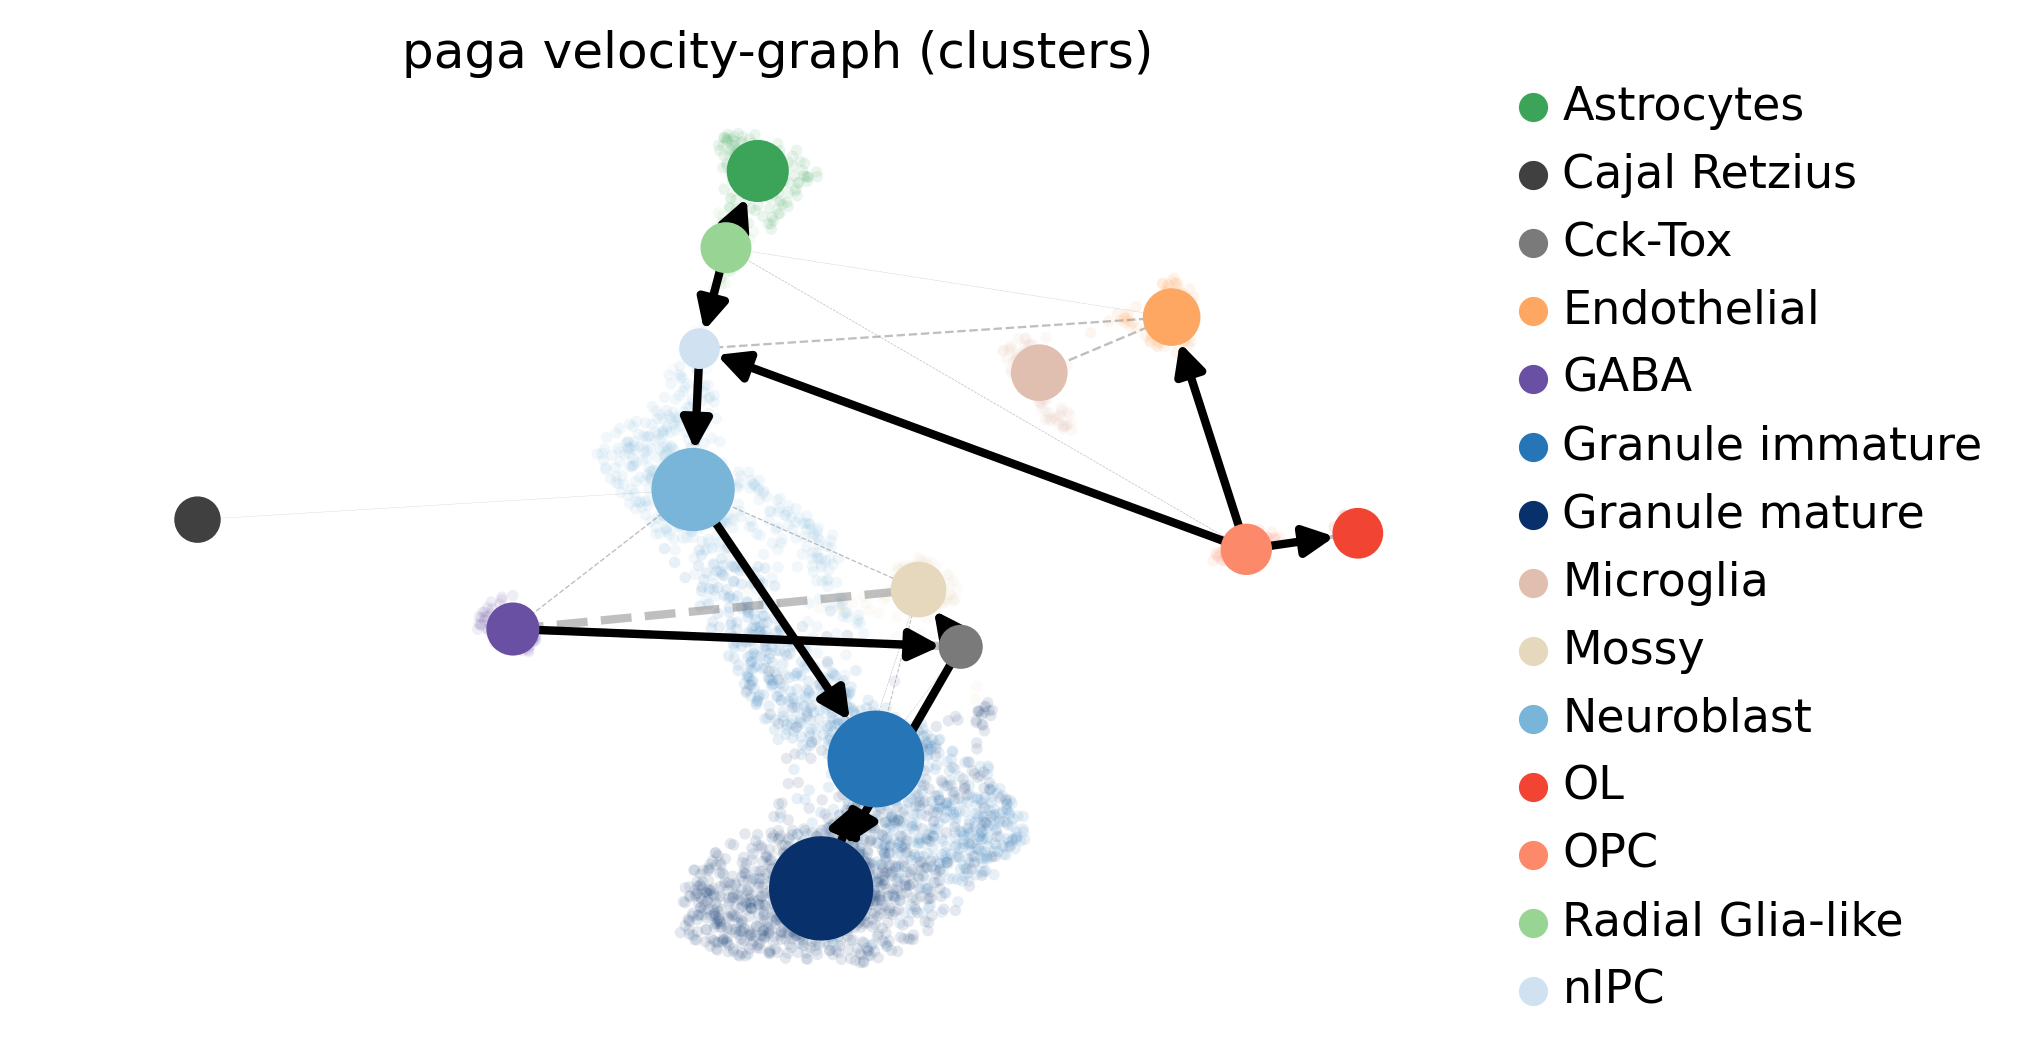

In [19]:
# trajectory inference
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']
scv.tl.paga(adata, groups="clusters")
scv.pl.paga(
    adata,
    basis="umap",
    size=30,
    alpha=0.1,
    min_edge_width=2,
    node_size_scale=1,
    dpi=150,
)

In [20]:
# save adata for next steps
dynamical_adata = adata.copy()

# Compare consistency score

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
DeepVelo mean score: 0.9456, std: 0.0357
Dynamical mean score: 0.8009, std: 0.1074


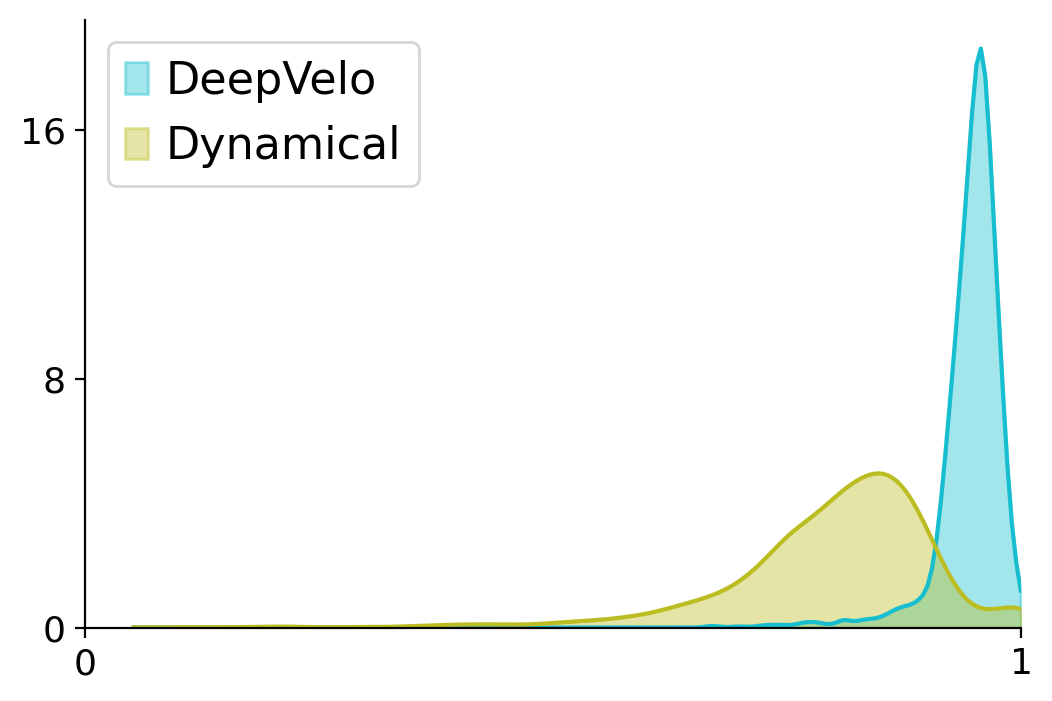

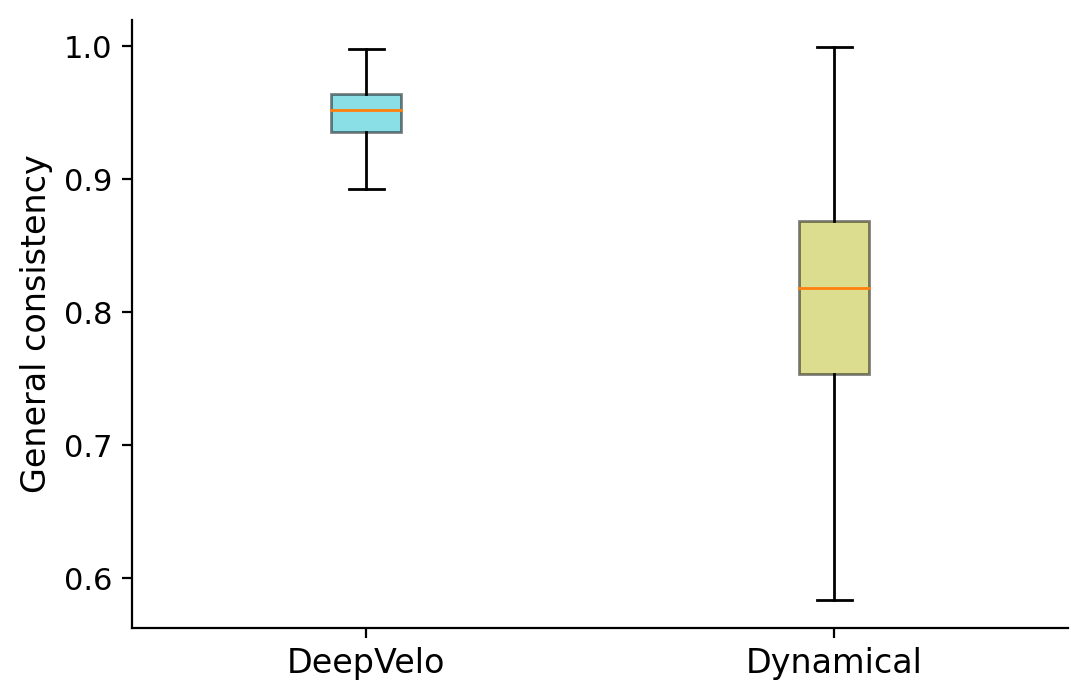

In [21]:
vkey = "velocity"
method = "cosine"
velocity_confidence(deepvelo_adata, vkey=vkey, method=method)
velocity_confidence(dynamical_adata, vkey=vkey, method=method)
compare_plot(deepvelo_adata, dynamical_adata, method=method)

In [22]:
# Mann-Whitney U Test test
stat, p = mannwhitneyu(
    deepvelo_adata.obs["velocity_confidence_cosine"].tolist(),
    dynamical_adata.obs["velocity_confidence_cosine"].tolist(),
)
print(f"Statistics={stat:.3f}, {p}")
# interpret
alpha = 0.05
if p > alpha:
    print("Same distribution (fail to reject H0)")
else:
    print("Different distribution (reject H0)")


Statistics=525682.000, 0.0
Different distribution (reject H0)


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence_cosine' (adata.obs)
DeepVelo mean score: 0.8379, std: 0.0885
Dynamical mean score: 0.6077, std: 0.1430


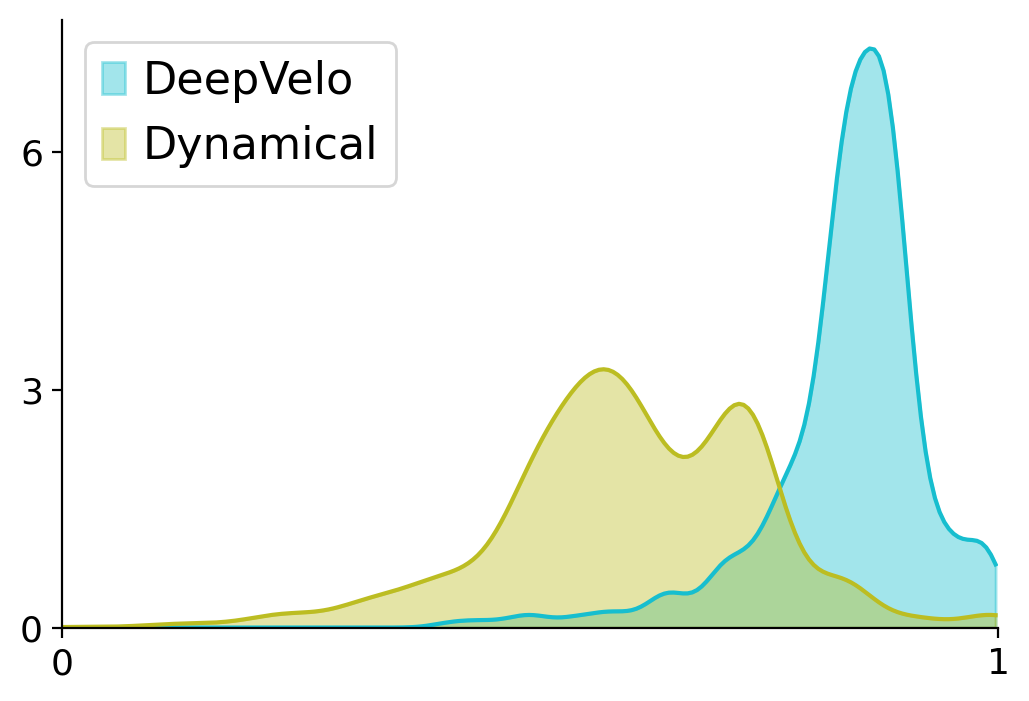

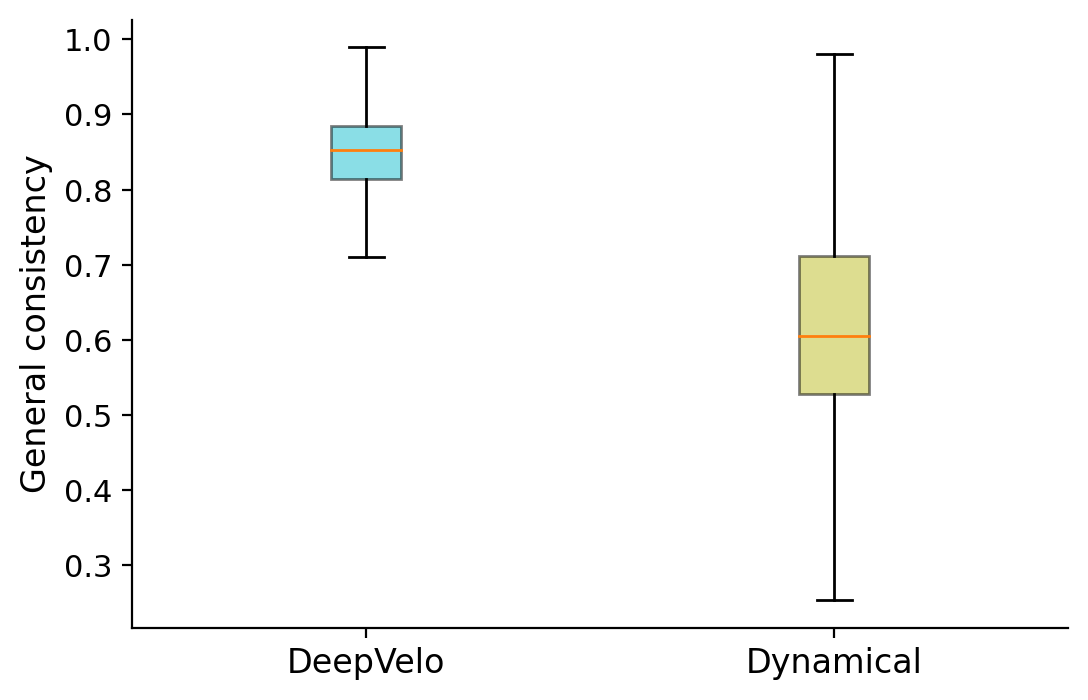

In [23]:
vkey = "velocity"
method = "cosine"
scope_key = "clusters"
# 3. cosine similarity, compute within Celltype
velocity_confidence(deepvelo_adata, vkey=vkey, method=method, scope_key=scope_key)
velocity_confidence(dynamical_adata, vkey=vkey, method=method, scope_key=scope_key)
compare_plot(deepvelo_adata, dynamical_adata, method=method)

In [24]:
# Mann-Whitney U Test test
stat, p = mannwhitneyu(
    deepvelo_adata.obs["velocity_confidence_cosine"].tolist(),
    dynamical_adata.obs["velocity_confidence_cosine"].tolist(),
)
print(f"Statistics={stat:.3f}, {p}")
# interpret
alpha = 0.05
if p > alpha:
    print("Same distribution (fail to reject H0)")
else:
    print("Different distribution (reject H0)")

Statistics=637068.000, 0.0
Different distribution (reject H0)
